In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import cv2

import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision import transforms
import torchvision 
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.utils import shuffle
import torchvision.models as models
import gc
from tqdm import tqdm
import torch.optim as optim
import random
import pandas as pd
from sklearn.utils import shuffle
import time

Prepare data

In [28]:
train_path = "train_dataset"
path_train = []
label_train = []
for root, dirs, files in os.walk(train_path): # loop 2 รอบคือ cats, dogs
  for name in files: # loop ข้างในของ cats กับ dog
    filename = os.path.join(root, name)
    path_train.append(filename)

#labels
for i in path_train: # loop ตามจำนวน path
    parts = i.rsplit('\\', 2) # ตัดคำ เช่น 'train_dataset\\cats\\.DS_Store' => 'train_dataset','cats','.DS_Store'
    if len(parts) >= 2: 
        label = parts[-2] # เลือกตำแหน่ง 2 คือ cats กับ dogs
        label_train.append(label)
    else:
        print(f"Path format error: {i}")

In [29]:
valid_path = "test_dataset"
path_valid = []
label_valid = []
for root, dirs, files in os.walk(valid_path):
  for name in files:
    filename = os.path.join(root, name)
    path_valid.append(filename)
    
#labels
for i in path_valid:
    label = i.rsplit('\\', 2)[-2]
    label_valid.append(label)

Label data

การ encode label data เราจะกำหนดให้ dog = 1 และ cat = 0

In [30]:
df_train_data = {'Images':path_train, 'labels':label_train} 
df_train_data = pd.DataFrame(df_train_data) 
df_train_data["encoded_labels"] = df_train_data["labels"].apply(lambda x : 0 if x == "cats" else 1)
df_train_data.head()

,Images,labels,encoded_labels
0,train_dataset\cats\cat.1.jpg,cats,0
1,train_dataset\cats\cat.10.jpg,cats,0
2,train_dataset\cats\cat.100.jpg,cats,0
3,train_dataset\cats\cat.1000.jpg,cats,0
4,train_dataset\cats\cat.1001.jpg,cats,0


In [31]:
df_valid_data = {'Images':path_valid, 'labels':label_valid}
df_valid_data = pd.DataFrame(df_valid_data) 
df_valid_data["encoded_labels"] = df_valid_data["labels"].apply(lambda x : 0 if x == "cats" else 1)
df_valid_data.head()

,Images,labels,encoded_labels
0,test_dataset\cats\cat.4001.jpg,cats,0
1,test_dataset\cats\cat.4002.jpg,cats,0
2,test_dataset\cats\cat.4003.jpg,cats,0
3,test_dataset\cats\cat.4004.jpg,cats,0
4,test_dataset\cats\cat.4005.jpg,cats,0


ใช้ shuffle เพื่อทำการสุ่มค่าจัดเรียงค่าแบบสุ่มใน dataframe แทนที่การทำใน dataloader

In [32]:
df_train_data = shuffle(df_train_data, random_state=0)
df_valid_data = shuffle(df_valid_data, random_state=0)

df_train_data.head()

,Images,labels,encoded_labels
3069,train_dataset\cats\cat.3761.jpg,cats,0
1675,train_dataset\cats\cat.2506.jpg,cats,0
6385,train_dataset\dogs\dog.3145.jpg,dogs,1
543,train_dataset\cats\cat.1488.jpg,cats,0
3213,train_dataset\cats\cat.3891.jpg,cats,0


In [33]:
df_valid_data.head()

,Images,labels,encoded_labels
405,test_dataset\cats\cat.4406.jpg,cats,0
1190,test_dataset\dogs\dog.4191.jpg,dogs,1
1132,test_dataset\dogs\dog.4133.jpg,dogs,1
731,test_dataset\cats\cat.4732.jpg,cats,0
1754,test_dataset\dogs\dog.4755.jpg,dogs,1


Create dataset and dataloader

In [34]:
CONFIG = {
    'EPOCHS': 10,
    'img_size': 256,
    'seed': 22, # เริ่มต้นการสุ่มด้วยจุดเริ่มต้น 22
    'train_batch_size': 32,
    'test_batch_size': 32,
    'num_classes': 2,
}

CONFIG

{'EPOCHS': 10,
 'img_size': 256,
 'seed': 22,
 'train_batch_size': 32,
 'test_batch_size': 32,
 'num_classes': 2}

In [35]:
torch.manual_seed(101) #เพื่อให้การสุ่ม(shuffle)เป็นแบบเดิมทุกครั้งที่รัน
train_transform = transforms.Compose([transforms.ToPILImage(),  # แปลงจาก tensor หรือ array เป็นภาพแบบ PIL
                                      transforms.ToTensor(),  # แปลงภาพกลับมาเป็น tensor (ค่า pixel อยู่ในช่วง 0-1)
                                      transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])), # ปรับขนาดภาพเป็นขนาดที่กำหนดใน config
                                      transforms.RandomHorizontalFlip(),  # พลิกภาพแบบสุ่มทางแนวนอน (augmentation)
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])   # ปรับค่า pixel RGB ให้กระจายรอบศูนย์กลาง 0 คำนวณแบบ (x - mean) / std

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [36]:
# เพื่อโหลดภาพจาก path ที่เก็บไว้ใน DataFrame (pandas) พร้อมทำ transformation และคืนค่าภาพพร้อม label ทีละภาพ
class CustomImageDataset(Dataset):
  def __init__(self, df, transform=None): # initialize dataset
    self.df = df
    self.file_names = df['Images'].values
    self.labels = df['encoded_labels'].values
    self.transform = transform

  def __len__(self): # บอกจำนวนข้อมูลทั้งหมดใน dataset
    return len(self.labels)

  def __getitem__(self, idx): # คืน (ภาพ, label) ทีละภาพ ใช้ OpenCV อ่านภาพ
    img_path = self.file_names[idx]
    labels = self.labels[idx]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR) # อ่านภาพด้วย OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # แปลงจาก BGR เป็น RGB (เพราะ OpenCV ใช้ BGR)
    if self.transform:
      image = self.transform(image) # แปลงภาพตามเงือนไขข้างบน(train_transform)
    return image, labels

In [37]:
train_dataset = CustomImageDataset(df_train_data,  train_transform) # สร้าง Dataset
valid_dataset = CustomImageDataset(df_valid_data,  valid_transform)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset,batch_size=CONFIG["test_batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


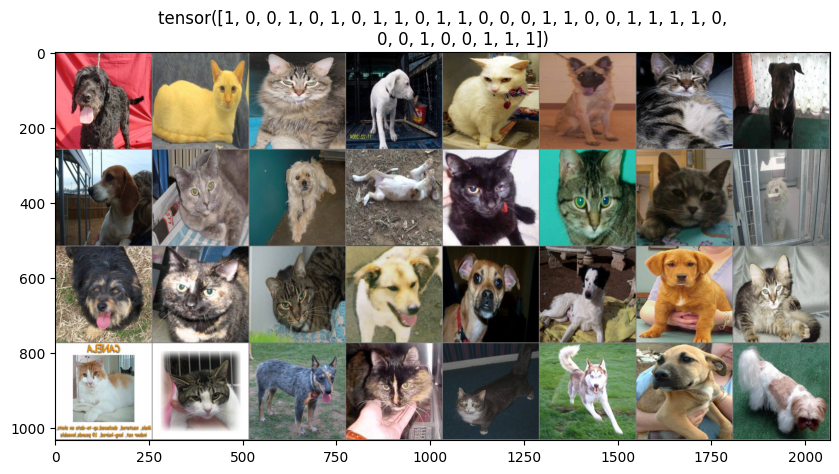

In [38]:
def imshow(img, title = None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # แปลงจาก PyTorch tensor เป็น numpy array เพื่อใช้กับ matplotlib
    plt.figure(figsize=(10,10)) # ตั้งขนาดรูปให้ใหญ่ขึ้น
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # ปลี่ยนรูปแบบจาก [C, H, W] → [H, W, C] เพื่อให้ matplotlib แสดงผลได้ถูกต้อง และ แสดงภาพด้วย matplotlib
    if title is not None: # ใส่ title ถ้ามี (แสดง label ถ้าส่งเข้ามา)
      plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter) # ดึง batch แรกออกมา

# show images
imshow(torchvision.utils.make_grid(images), title= labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


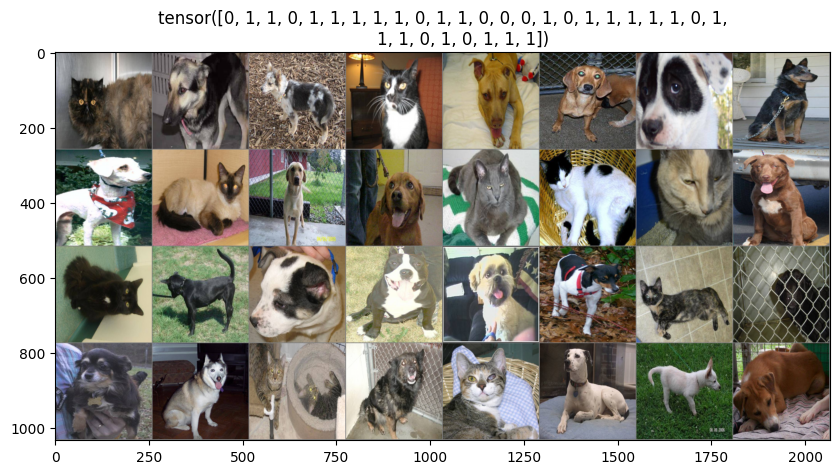

In [39]:
def imshow(img, title = None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
      plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), title= labels)

กำหนดการเรียกใช้ device ของ GPU

In [40]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

**Transformer**

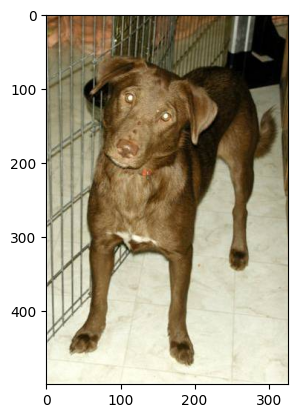

In [41]:
img = Image.open('train_dataset\dogs\dog.1.jpg')

fig = plt.figure()
plt.imshow(img)

In [42]:
# resize to imagenet size 
transform_test = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])# ปรับขนาน256x256และแปลงภาพจาก PIL.Image → torch.Tensor
x = transform_test(img) # torch.Size([3, 256, 256])
x = x.unsqueeze(0) # add batch dim เพิ่มมิติ
x.shape

torch.Size([1, 3, 256, 256])

In [43]:
patch_size = 16 # 16 pixels
pathes = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size) # "b=32 (h=16*w=16)=256 (16*16*3)=768" h*s1 =256
pathes

tensor([[[ 0.2357,  0.3210,  0.3367,  ...,  0.1957,  0.2192,  0.2585],
         [ 0.1478,  0.1622,  0.2014,  ...,  0.0574,  0.0809,  0.1201],
         [ 0.1264,  0.1499,  0.1891,  ...,  0.0423,  0.0659,  0.1051],
         ...,
         [-0.4152, -0.4802, -0.5536,  ..., -0.1988, -0.2739, -0.3553],
         [-0.3495, -0.4187, -0.4980,  ..., -0.4467, -0.4943, -0.5898],
         [-0.3320, -0.3869, -0.4663,  ..., -0.7998, -0.8077, -0.8234]],

        [[-0.1799, -0.2269, -0.2112,  ..., -0.1952, -0.2423, -0.2266],
         [-0.0588, -0.1059, -0.0902,  ..., -0.2752, -0.3222, -0.3066],
         [-0.1199, -0.1669, -0.1512,  ..., -0.0151, -0.0621, -0.0464],
         ...,
         [-0.3197, -0.3668, -0.3511,  ..., -0.3707, -0.4178, -0.4021],
         [-0.3831, -0.4301, -0.4144,  ...,  0.3818,  0.2720,  0.1857],
         [ 0.2673,  0.1499,  0.0706,  ..., -0.5106, -0.5577, -0.5420]],

        [[ 0.2603,  0.0642, -0.0927,  ...,  0.1730,  0.0305, -0.0512],
         [ 0.0042, -0.1729, -0.3208,  ...,  0

resnet 50

In [44]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.c = nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.bn(self.c(x))

In [45]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, first = False):
    super().__init__()
    res_channels = in_channels//4
    stride = 1

    self.projection = in_channels != out_channels
    if self.projection :
      self.p = ConvBlock(in_channels, out_channels, 1, 2, 0)
      stride = 2
      res_channels = in_channels // 2

    if first:
      self.p = ConvBlock(in_channels, out_channels, 1, 1, 0)
      stride = 1
      res_channels = in_channels

    self.c1 = ConvBlock(in_channels, res_channels, 1, 1, 0)
    self.c2 = ConvBlock(res_channels, res_channels, 3, stride, 1)
    self.c3 = ConvBlock(res_channels, out_channels, 1, 1, 0)
    self.relu = nn.ReLU()

  def forward(self, x):
    f = self.relu(self.c1(x))
    f = self.relu(self.c2(f))
    f = self.c3(f)

    if self.projection:
      x = self.p(x)

    h = self.relu(torch.add(f,x))
    return h

In [46]:
class ResNet(nn.Module):
  def __init__(self, config_name : int, in_channels = 3, classes = 2):
    super(ResNet, self).__init__()

    configurations = {
        50 : [3,4,6,3],
        101 : [3,4,23,3],
        152 : [3,8,36,3]
    }

    no_blocks = configurations[config_name]

    out_features = [256, 512, 1024, 2048]
    self.blocks = nn.ModuleList([ResidualBlock(64, 256, True)])

    for i in range(len(out_features)):
      if i > 0 :
        self.blocks.append(ResidualBlock(out_features[i-1], out_features[i]))
      for _ in range(no_blocks[i]-1):
        self.blocks.append(ResidualBlock(out_features[i], out_features[i]))

    self.conv1 = ConvBlock(in_channels, 64, 7, 2, 3)
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc1 = nn.Linear(2048, 512)
    self.fc2 = nn.Linear(512, classes)
    self.relu = nn.ReLU()
    self.init_weight()

    #resnet50 + tranformers 
    self.conv2 = nn.Conv2d(in_channels = 2048,out_channels =  192,kernel_size =  3, stride = 1, padding = 1)#emb_size = 192*2*2

  def init_weight(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    for block in self.blocks:
      x = block(x)

    #resnet50 + tranformers 
    p = self.conv2(x)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x, p 

In [47]:
resnet50 = ResNet(50)
resnet50.to(device)

ResNet(
  (blocks): ModuleList(
    (0): ResidualBlock(
      (p): ConvBlock(
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c1): ConvBlock(
        (c): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c2): ConvBlock(
        (c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c3): ConvBlock(
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1-2): 2 x ResidualBlock(
      (c1): ConvBlock(
        (c): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64,

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-5)

In [66]:
training_loss_res = []
training_Acc_res = []
validing_Acc_res = []
validing_loss_res = []

train_batch = CONFIG['train_batch_size']
start_res = time.time()

for epoch in range(CONFIG['EPOCHS']):
    gc.collect()
    resnet50.train()
    train_epoch_loss = 0
    train_epoch_acc = 0

    bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for step, batch in bar:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = resnet50(images)
        _, preds = torch.max(torch.softmax(outputs, dim=1), 1)
        running_corrects = torch.sum(preds == labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_acc += running_corrects.item() / train_batch

        bar.set_description(f'loss: {loss.item()} acc: {running_corrects.item()/train_batch} batch_id: {step}')
        bar.set_postfix(
            Epoch=epoch+1,
            Train_Loss=train_epoch_loss / len(train_dataloader),
            Train_ACC=train_epoch_acc / len(train_dataloader),
            LR=optimizer.param_groups[0]['lr']
        )

    training_loss_res.append(train_epoch_loss / len(train_dataloader))
    training_Acc_res.append(train_epoch_acc / len(train_dataloader))
    gc.collect()

    # ✅ Validation phase ต่อ epoch
    correct = 0
    total = 0
    val_epoch_loss = 0
    resnet50.eval()

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, _ = resnet50(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_epoch_loss += loss.item()

    valid_acc_res = correct / total
    valid_loss_res = val_epoch_loss / len(valid_dataloader)

    validing_Acc_res.append(valid_acc_res)
    validing_loss_res.append(valid_loss_res)

end_res = time.time()
res_time = end_res - start_res
print('Finished Training in', round(res_time, 2), 'seconds')

loss: 0.6745466589927673 acc: 0.59375 batch_id: 249: 100%|██████████| 250/250 [33:11<00:00,  7.97s/it, Epoch=1, LR=1e-5, Train_ACC=0.586, Train_Loss=0.674]   
loss: 0.6724613308906555 acc: 0.625 batch_id: 249: 100%|██████████| 250/250 [26:37<00:00,  6.39s/it, Epoch=2, LR=1e-5, Train_ACC=0.62, Train_Loss=0.651]   
loss: 0.6018525958061218 acc: 0.6875 batch_id: 249: 100%|██████████| 250/250 [25:01<00:00,  6.01s/it, Epoch=3, LR=1e-5, Train_ACC=0.649, Train_Loss=0.627] 
loss: 0.5599474906921387 acc: 0.78125 batch_id: 249: 100%|██████████| 250/250 [42:49<00:00, 10.28s/it, Epoch=4, LR=1e-5, Train_ACC=0.668, Train_Loss=0.609]    
loss: 0.6175072193145752 acc: 0.5625 batch_id: 249: 100%|██████████| 250/250 [21:58<00:00,  5.27s/it, Epoch=5, LR=1e-5, Train_ACC=0.684, Train_Loss=0.592]  
loss: 0.7003095149993896 acc: 0.625 batch_id: 249: 100%|██████████| 250/250 [26:02<00:00,  6.25s/it, Epoch=6, LR=1e-5, Train_ACC=0.703, Train_Loss=0.571]   
loss: 0.458665668964386 acc: 0.78125 batch_id: 249: 100

Finished Training in 17909.41 seconds


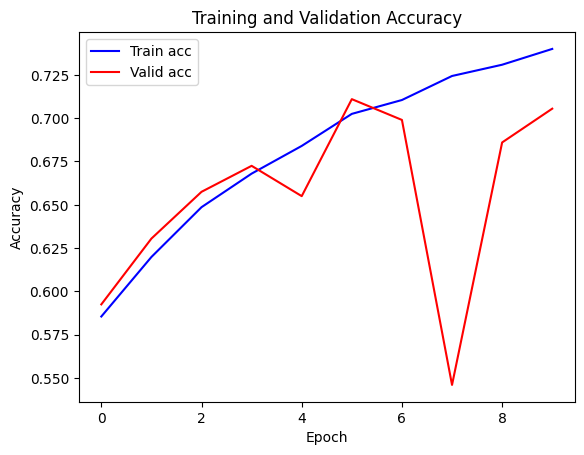

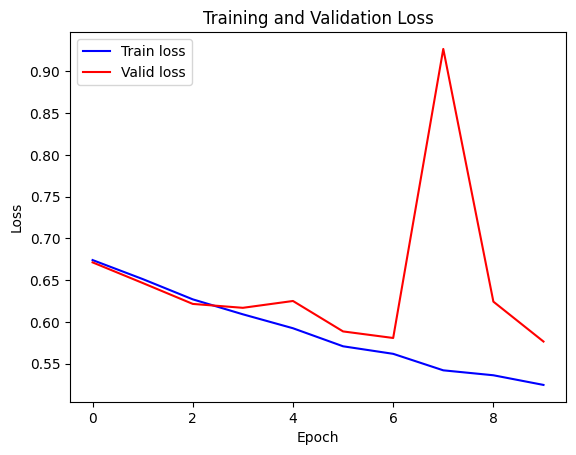

<Figure size 640x480 with 0 Axes>

In [67]:
epochs = range(CONFIG['EPOCHS'])

plt.plot(epochs, training_Acc_res, 'b', label='Train acc')
plt.plot(epochs, validing_Acc_res, 'r', label='Valid acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, training_loss_res, 'b', label='Train loss')
plt.plot(epochs, validing_loss_res, 'r', label='Valid loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [68]:
print(f'Validation Accuracy: {valid_acc_res * 100:.2f}%')
print(f'Validation Loss: {valid_loss_res:.4f}')

Validation Accuracy: 70.55%
Validation Loss: 0.5764


In [71]:
model_list = ["Resnet50"]
train_acc_list = [ round(training_Acc_res[-1],2) ]
train_loss_list = [round(training_loss_res[-1],4)]
valid_acc_list = [valid_acc_res]
time_compute = [res_time]
df_eval = {'model':model_list, 'train_accuracy':train_acc_list, "train_loss": train_loss_list, "valid_accuracy" : valid_acc_list, "time_computing(sec)" : time_compute} 
df_eval = pd.DataFrame(df_eval)
df_eval

,model,train_accuracy,train_loss,valid_accuracy,time_computing(sec)
0,Resnet50,0.74,0.5244,0.7055,17909.407561
